In [31]:
from wandb.keras import WandbCallback
import wandb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow import convert_to_tensor
import numpy as np
from transformers import TFDistilBertModel
from extract_bert_features import embed, get_pipe
from model_k import create_model
from scipy.spatial.distance import cosine
from tensorflow.keras.callbacks import EarlyStopping
from progress.bar import Bar
import pandas as pd

from timer import timer

import matplotlib.pyplot as plt

from spacyNER import training_data_per_entity_spacy


# IMPORT import df from file


In [32]:
import pandas as pd
from data import get_training_data

# train_x/y has only the embeddings
train_x, test_x, train_y, test_y = get_training_data(
    save_dir="results",
    radius=10,
    fraction=0.99,
    count=-1,
    force_recreate=True,
    entity_filter=['PER','ORG','LOC'])


Finished 'get_pipe' in 6.227 secs


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/113211 [00:00<?, ?it/s]


UnboundLocalError: local variable 'sentence' referenced before assignment

In [16]:
# plot loss
# summarize history for loss
def plot_loss(history) -> None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


grid search

In [17]:
default = {
    "ae": [
        {"n": 768, "act": "relu"},
        {"n": 500, "act": "relu"},
        {"n": 2000, "act": "relu"},
    ],
    "repr": [
        {"n": 2000, "act": "relu"},
        {"n": 768, "act": "relu"},
        {"n": 768, "act": "relu"},
    ],
    "latent": {"n": 160, "act": "relu"},
    "output": "sigmoid",
    "opt": "adam",
    "loss": "mse",
    "lr": 0.001,
    "batch": 256
}

grid = [
    # big
    {
        "name": "4 deep big - 160 latent",
        **default,

        "output": "tanh",
    },
    # sigmoid
    # {
    #     "name": "1 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "2 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # {
    #     "name": "3 deep - 160 latent",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    # },
    # tanh
    # {
    #     "name": "1 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "2 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 400, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },
    # {
    #     "name": "3 deep - 160 latent - tanh",
    #     **default,
    #     "layers": [
    #         {"n": 768, "act": "relu"},
    #         {"n": 512, "act": "relu"},
    #         {"n": 256, "act": "relu"},
    #     ],
    #     "latent": {"n": 160, "act": "relu"},
    #     "output": "tanh",
    # },


]


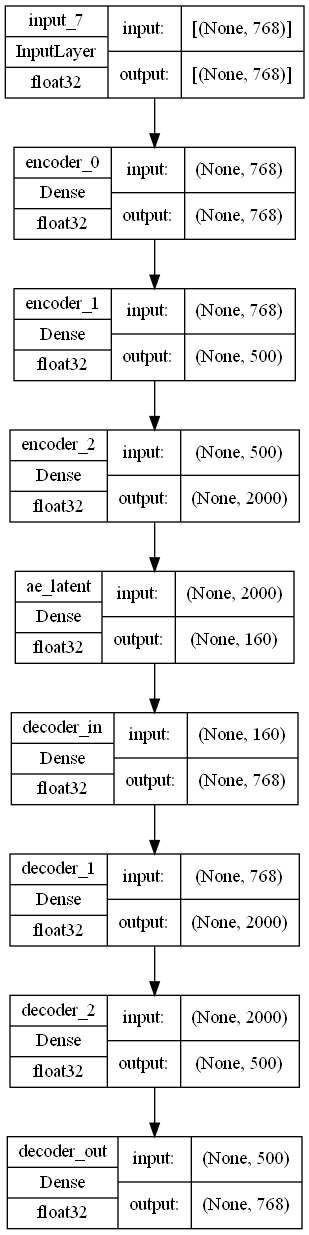

In [18]:
model = create_model(grid[0])
plot_model(model, show_dtype=True, 
            show_layer_names=True, show_shapes=True)

Full df: (3895, 771)
Train df: (3116, 768)
Test df: (779, 768)
Training 4 deep big - 160 latent
Epoch 34: early stopping
...Loss => 6.633363246917725


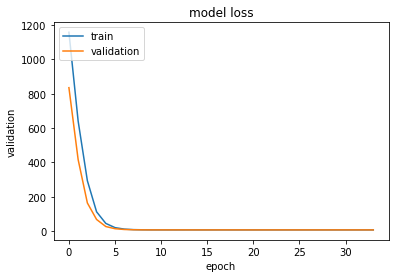

In [19]:

early_stopping_cb = EarlyStopping(
    monitor='loss', patience=15, verbose=1, min_delta=0.0001)

for config in grid:
    train_x, test_x = test_train_split()
    model = create_model(config)
    print(f"Training {config['name']}")
    plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True)
    history = model.fit(
        train_x,
        train_x,
        validation_data=(test_x, test_x),
        epochs=2000,
        batch_size=config["batch"],
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping_cb],
    )
    print(f"...Loss => {history.history['loss'][-1]}")
    plot_loss(history)

In [ ]:
# find best latent dims
early_stopping_cb = EarlyStopping(
    monitor='loss', patience=10, verbose=1, min_delta=0.00001)

best_loss = {"dims": 0, "loss": 100}
test_dims = [16, 32, 48, 64, 96, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 256, 512, 768]
# test_dims = range(140, 180, 1)
# test_dims = [168]
test_batches = [1024]
test_history = []
for latent_dim in test_dims:
    for batch_size in test_batches:
        model = create_model(
            layers=[
                {"n": 768, "act": "relu"},
                # {"n": 512, "act": "relu"},
                # {"n": 256, "act": "relu"},
            ],
            latent_layer={"n": latent_dim, "act": "relu"},
            output_fn="tanh",
            optimizer_fn="adam",
            loss_fn="mse",
            verbose=0)
        print(f"Training {latent_dim} latent dims, batch: {batch_size}")
        history = model.fit(
            train_x,
            train_x,
            validation_data=(test_x, test_x),
            epochs=2000,
            batch_size=1024,
            validation_split=0.1,
            shuffle=True,
            verbose=0,
            callbacks=[early_stopping_cb],
        )
        loss = history.history['val_loss'][-1]
        print(f"...Loss => {loss}")
        test_history.append(loss)
        if loss < best_loss["loss"]:
            best_loss = {
                "dims": latent_dim, "loss": loss, "batch_size": batch_size}

# results
plt.plot(test_dims, test_history)
plt.title('autoencoder loss vs latent dims')
plt.ylabel('loss')
plt.xlabel('dimensions')
plt.show()
print(
    f"Best latent dims: {best_loss['dims']}, "
    f"batch:{best_loss['batch_size']} => {best_loss['loss']}")

# DEC approach

In [ ]:
from train_DEC import run_model

## Spacy fit on CoNLL

In [12]:
run_model("conll")


Loading conll
Loaded from file results\training_data_radius_conll_all_0.csv
Full df: (709, 772)
Train df: (702, 768)
Test df: (7, 768)
conll dataset: (702, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
2 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                  

In [5]:
run_model("conll")

conll dataset: (1274, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
2 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 2)                20        
 )                  

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Iter 0: acc = 0.63265, nmi = 0.05177, ari = 0.06966  ; loss= 0
saving model to: ./results/DEC_model_0.h5
saving model to: ./results/DEC_model_10.h5
saving model to: ./results/DEC_model_20.h5
Iter 30: acc = 0.64443, nmi = 0.06153, ari = 0.08272  ; loss= 0.00429
saving model to: ./results/DEC_model_30.h5
saving model to: ./results/DEC_model_40.h5
saving model to: ./results/DEC_model_50.h5
Iter 60: acc = 0.66013, nmi = 0.07590, ari = 0.10186  ; loss= 0.0068
saving model to: ./results/DEC_model_60.h5
saving model to: ./results/DEC_model_70.h5
saving model to: ./results/DEC_model_80.h5
Iter 90: acc = 0.66405, nmi = 0.07925, ari = 0.10695  ; loss= 0.01393
saving model to: ./results/DEC_model_90.h5
saving model to: ./results/DEC_model_100.h5
saving model to: ./results/DEC_model_110.h5
Iter 120: acc = 0.66719, nmi = 0.08232, ari = 0.11111  ; loss= 0.02487
saving model to: ./results/DEC_model_120.h5
saving model to: ./results/DEC_model_130.h5
saving model to: ./results/DEC_model_140.h5
Iter 150


# fewNERD data

In [13]:
run_model("fewNERD")

Loading fewNERD
Loaded from file results\training_data_radius_fewNERD_all_0.csv
Full df: (232415, 772)
Train df: (230091, 768)
Test df: (2324, 768)
conll dataset: (230091, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
4 clusters
Loading weights
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     


In [8]:
from data import pre_embed


df = pre_embed("fewNERD")

In [9]:
df.head()


,sentence,embeddings
0,Paul International airport,"[[-0.2806660830974579, 0.10220436006784439, -0..."
1,It starred Hicks wife Ellaline Terriss and Edm...,"[[-0.41176339983940125, -0.07411830872297287, ..."
2,Time magazine said the film was a multimillion...,"[[-0.03764878585934639, -0.08311532437801361, ..."
3,Pakistani scientists and engineers working at ...,"[[-0.1338706761598587, -0.18774892389774323, -..."
4,In February 2008 Church Chicken entered the UK...,"[[0.08807772397994995, -0.014405746012926102, ..."


In [10]:
from spacyNER import training_data_from_embeds_spacy
    
training_data_from_embeds_spacy(df[0:5],0)[1]


c:\Users\Will\Projects\MSc\project\spacyNER.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeds["spacy_data"] = embeds["sentence"].apply(nlp)


Create Training Data for 5 items, radius 0
Created NER Data for 5 items


5it [00:00, 2500.78it/s]

Created 19 training items


{'sentence': 'Hicks wife',
 'chunk': 'Hicks wife',
 'label': 383,
 'label_id': 'ORG',
 'embedding': array([-4.65280935e-02, -1.68413743e-01,  3.84316683e-01, -4.33038712e-01,
        -2.40251273e-01,  8.60882699e-01,  2.95584351e-01, -6.74185276e-01,
        -4.27742213e-01, -1.65889233e-01,  1.52874663e-01, -1.86812561e-02,
         8.21733251e-02, -9.32970792e-02, -1.06729493e-01,  3.03450346e-01,
        -6.15958095e-01,  9.93717015e-02,  2.80903697e-01, -3.01791072e-01,
         4.75539416e-01,  2.63143122e-01, -2.00853124e-02,  4.33730304e-01,
         3.39341849e-01, -1.07283451e-01,  1.59340978e-01, -2.94141531e-01,
        -5.59113204e-01,  2.45215386e-01,  4.10897434e-01,  1.47323698e-01,
         1.43525124e-01,  2.26344585e-01, -3.09008449e-01, -3.30858827e-02,
        -2.63573050e-01,  2.48830020e-03, -4.43948209e-01, -6.32656962e-02,
        -2.65011907e-01, -1.12137496e+00, -4.86013070e-02,  2.74530798e-02,
        -2.07271427e-01,  5.97828105e-02,  7.97798991e-01, -2.071

# fewNERD with Spacy NER

In [7]:
run_model("fewNERD_spacy", 10000, force_recreate=True, radius=0)

Create Training Data for 10000 items, radius 0
Created NER Data for 10000 items


1it [00:03,  3.58s/it]c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
10000it [00:04, 2437.84it/s]


Created 16210 training items
conll dataset: (24768, 768) x:<class 'numpy.ndarray'>, y:<class 'numpy.ndarray'>
4 clusters
Loading weights
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 4)               

# DEC+Spacy

In [1]:
%reload_ext autoreload
%autoreload 2

# compare
import numpy as np
import pandas as pd 
import os
import pickle

from data import load_data


In [2]:
x, y, mapping = load_data(1000)

Creating data


Reusing dataset conll2003 (C:\Users\Will\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

Reading lines


100%|██████████| 1000/1000 [00:00<00:00, 500274.81it/s]


Finished 'get_pipe' in 5.64 secs


100%|██████████| 1000/1000 [01:08<00:00, 14.60it/s]

Idx: 0 Label: 1
Idx: 1 Label: 0
Idx: 2 Label: 1
Idx: 3 Label: 1
Idx: 4 Label: 2
Idx: 5 Label: 1
Idx: 6 Label: 0
Idx: 7 Label: 2
Idx: 8 Label: 1
Idx: 9 Label: 0
Idx: 10 Label: 1
Idx: 11 Label: 1
Idx: 12 Label: 0
Idx: 13 Label: 0
Idx: 14 Label: 1
Idx: 15 Label: 2
Idx: 16 Label: 2
Idx: 17 Label: 0
Idx: 18 Label: 0
Idx: 19 Label: 0
Idx: 20 Label: 1
Idx: 21 Label: 1
Idx: 22 Label: 0
Idx: 23 Label: 0
Idx: 24 Label: 1
Idx: 25 Label: 2
Idx: 26 Label: 2
Idx: 27 Label: 0
Idx: 28 Label: 1
Idx: 29 Label: 1
Idx: 30 Label: 3
Idx: 31 Label: 2
Idx: 32 Label: 1
Idx: 33 Label: 0
Idx: 34 Label: 1
Idx: 35 Label: 2
Idx: 36 Label: 2
Idx: 37 Label: 2
Idx: 38 Label: 2
Idx: 39 Label: 2
Idx: 40 Label: 0
Idx: 41 Label: 2
Idx: 42 Label: 0
Idx: 43 Label: 2
Idx: 44 Label: 0
Idx: 45 Label: 0
Idx: 46 Label: 0
Idx: 47 Label: 2
Idx: 48 Label: 2
Idx: 49 Label: 1
Idx: 50 Label: 2
Idx: 51 Label: 2
Idx: 52 Label: 3
Idx: 53 Label: 2
Idx: 54 Label: 0
Idx: 55 Label: 2
Idx: 56 Label: 1
Idx: 57 Label: 0
Idx: 58 Label: 1
Idx: 59

In [3]:
from train_DEC import train_DEC
from metrics import acc

# %%timeit 
dec = train_DEC(x, y)
update_interval = 30
y_pred = dec.fit(x, y=y, tol=0.001, maxiter=2e4, batch_size=512,
    update_interval=update_interval, save_dir='./data')

print('acc:', acc(y, y_pred))

dataset x:(13892, 768) y:(13892,)
4 clusters
Loading weights
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 clustering (ClusteringLayer  (None, 4)                40        
 )                                                               


In [4]:
import matplotlib.pyplot as plt
def plot_loss(history) -> None:
    plt.plot(history['loss'])
    plt.plot(history['acc'])
    plt.plot(history['delta_label'])
    plt.plot(history['correct_label'])

    plt.title('model loss')
    plt.ylabel('validation')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy', 'delta', 'correct'], loc='upper left')
    plt.show()

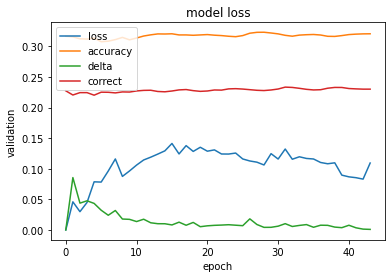

In [5]:

plot_loss(dec.history)

In [23]:
n = 1000
comp = y[0:n]==y_pred[0:n]
print (comp.sum(), comp.sum()/n)

205 0.205


# Deep Clustering

In [1]:
%reload_ext autoreload
%autoreload 2

# compare
import numpy as np
import pandas as pd 
import os
from spacyNER import get_training_data_spacy
from data_conll import get_sample_conll_hf
from train_DEC import entity_types

size = 100
filename = f"./data/conll_spacy_{size}.pkl"
if os.path.exists(filename):
    print(f"Loading {filename}")
    trg = pd.read_pickle(filename)
else:
    sample_conll = get_sample_conll_hf(size)

    trg = get_training_data_spacy(sample_conll, 0, entity_filter=entity_types)
    trg.to_pickle(filename)

print(f'Done: {trg.shape}')

Loading ./data/conll_spacy_100.pkl
Done: (121, 772)


In [2]:
from data import test_train_split

x, _, y, _ = test_train_split(trg)
print(f"x: {x.shape}, y: {y.shape}")

x: (204, 768), y: (204,)


In [21]:
%reload_ext autoreload
%autoreload 2
from model_tf2 import ClusterNetwork

reuters = ClusterNetwork(
    latent_dim = 10,
    latent_weight = 0.001,
    noise_factor = 0.4,
    keep_prob = 1.0,
    alpha1=20,
    alpha2=1,
    optimizer='adam',
    learning_rate=0.001,
    n_clusters=4,
).train(x, y, train_batch_size=100, pretrain_epochs=5, train_epochs=50)


ValueError: No gradients provided for any variable: ["<tf.Variable 'encoder/dense/kernel:0' shape=(768, 500) dtype=float32>", "<tf.Variable 'encoder/dense/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'encoder/dense_1/kernel:0' shape=(500, 500) dtype=float32>", "<tf.Variable 'encoder/dense_1/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'encoder/dense_2/kernel:0' shape=(500, 2000) dtype=float32>", "<tf.Variable 'encoder/dense_2/bias:0' shape=(2000,) dtype=float32>", "<tf.Variable 'encoder/dense_3/kernel:0' shape=(2000, 10) dtype=float32>", "<tf.Variable 'encoder/dense_3/bias:0' shape=(10,) dtype=float32>", "<tf.Variable 'decoder/dense_4/kernel:0' shape=(10, 2000) dtype=float32>", "<tf.Variable 'decoder/dense_4/bias:0' shape=(2000,) dtype=float32>", "<tf.Variable 'decoder/dense_5/kernel:0' shape=(2000, 500) dtype=float32>", "<tf.Variable 'decoder/dense_5/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'decoder/dense_6/kernel:0' shape=(500, 500) dtype=float32>", "<tf.Variable 'decoder/dense_6/bias:0' shape=(500,) dtype=float32>", "<tf.Variable 'decoder/dense_7/kernel:0' shape=(500, 768) dtype=float32>", "<tf.Variable 'decoder/dense_7/bias:0' shape=(768,) dtype=float32>"].

# TF2 from scratch

In [1]:
from tensorflow import keras as k
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from random import shuffle
from data import test_train_split

def load_data(size: int):
    filename_data = f"./data/conll_spacy_{size}.pkl"
    filename_mapping = f"./data/conll_spacy_{size}_map.pkl"
    if os.path.exists(filename_data) and os.path.exists(filename_mapping):
        print(f"Loading {filename_data}")
        trg = pd.read_pickle(filename_data)
        with open(filename_mapping, 'rb') as handle:
            mapping = pickle.load(handle)
    else:
        sample_conll = get_sample_conll_hf(size)

        trg, mapping = get_training_data_spacy(sample_conll, 0, entity_filter=entity_types)
        trg.to_pickle(filename_data)
        with open(filename_mapping, 'wb') as handle:
            pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)


    print(f'Done: {trg.shape}')
    print(mapping)


In [3]:
embeddings_dims = 768
latent_dims = 256

input_layer = k.Input(shape=(embeddings_dims,))

enc1 = tf.keras.layers.Dense(500)(input_layer)
enc2 = tf.keras.layers.Dense(500)(enc1)
enc3 = tf.keras.layers.Dense(2000)(enc2)

enc_X_out_logits = tf.keras.layers.Dense(latent_dims)(enc3)
encoder = tf.nn.sigmoid(enc_X_out_logits)
encoder_model = tf.keras.Model(inputs=input_layer, outputs=encoder)


In [4]:

dec1 = tf.keras.layers.Dense(2000)(enc_X_out_logits)
dec2 = tf.keras.layers.Dense(500)(dec1)
dec4 = tf.keras.layers.Dense(500)(dec2)

dec_X_out_logits = tf.keras.layers.Dense(embeddings_dims)(dec4)
decoder = tf.nn.sigmoid(dec_X_out_logits)
ae_model = k.models.Model(inputs=input_layer, outputs=decoder)


In [5]:

lat1 = tf.keras.layers.Dense(2000)(enc_X_out_logits)
lat2 = tf.keras.layers.Dense(500)(lat1)
lat3 = tf.keras.layers.Dense(500)(lat2)
lat4 = tf.keras.layers.Dense(500)(lat3)
latent_network = tf.keras.layers.Dense(latent_dims)(lat4)
latent_model = k.models.Model(inputs=input_layer, outputs=latent_network)

model = k.models.Model(inputs=input_layer, outputs=[decoder, latent_network])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [6]:
# @tf.function
# def latent_model(z_enc, training):
#     z = latent_network(z_enc, training)

#     p = make_q(z_enc, batch_size, alpha=alpha1)
#     q = make_q(z, batch_size, alpha=alpha2)

#     latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))


In [7]:
# @tf.function
# def ae_model_iter(X, training, rec_loss="mse"):

#         # Add noise to the input to feed to Denoising encoder model.
#         X_noisy = X + noise_factor * \
#             tf.random.normal(shape=tf.shape(X), mean=0.0,
#                              stddev=1.0, dtype=tf.float64)
#         X_noisy = tf.clip_by_value(X, 0.0, 1.0)

#         # Pass through encoder and decoder.
#         z = encoder(X_noisy, training)
#         X_out_logits, X_out = decoder(z, training)

#         # Calculate Reconstruction loss.
#         if rec_loss == 'mse':
#             reconstr_loss = tf.reduce_mean(
#                 tf.math.squared_difference(X, X_out), axis=1)
#         else:
#             reconstr_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
#                 labels=X, logits=X_out_logits), axis=1)
#         reconstr_loss = tf.reduce_mean(reconstr_loss)

#         return reconstr_loss, z
        

In [8]:
@tf.function
def pairwise_sqd_distance(X, batch_size):
    tiled = tf.tile(tf.expand_dims(X, axis=1),
                    tf.stack([1, batch_size, 1]))
    tiled_trans = tf.transpose(tiled, perm=[1, 0, 2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

    return sqd_dist_mat

In [9]:
@tf.function
def make_q(z, batch_size, alpha):

    sqd_dist_mat = pairwise_sqd_distance(z, batch_size)
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / (tf.reduce_sum(q, axis=0, keepdims=True)+1e-9)
    #q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)

    return q

In [10]:
def batches(x, y, n):
    for i in range(0, (y.shape[0] // n)-1):
        yield x[i*n:(i*n)+n], y[i*n:(i*n)+n]

In [11]:
x, y = load_data(100)

Loading ./data/conll_spacy_100.pkl
x: (204, 768), y: (204,)


Pretraining
Pretraining final loss [0.19718921 0.17569768 0.1342979  0.15947612 0.10982829 0.14159004
 0.1675571  0.19017065 0.15013658 0.15013658 0.15674998 0.20314276
 0.13158505 0.19017065 0.19718921 0.1675571  0.16552472 0.16576435
 0.17294478 0.15936284 0.14076886 0.14341438 0.17194922 0.17330475
 0.17662804 0.14766388 0.14246221 0.18252091 0.12228134 0.12228134
 0.18252091 0.12228134]
Full training


100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


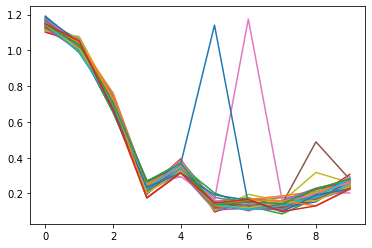

In [12]:
%matplotlib inline

losses = []
alpha1 = 20
alpha2 = 1
rec_weight = 1.0
latent_weight = 0.01
batch_size = 32
num_epochs = 2

# pretrain ae
print("Pretraining")
pretrain_batches = batches(x, y, batch_size)
for batch_idx, (x_batch, y_batch) in enumerate(pretrain_batches):
    if batch_idx > 20:
        break
    with tf.GradientTape() as tape:
        y_reconst = ae_model(x_batch, training=True)

        reconstr_loss = tf.reduce_mean(
            tf.math.squared_difference(x_batch.astype('float32'), y_reconst), axis=1)

    gradients = tape.gradient(reconstr_loss, tape.watched_variables())
    # apply gradients for all variables watched by the tape
    opt.apply_gradients((grad, var)
                        for (grad, var) in zip(gradients, tape.watched_variables())
                        if grad is not None)
print(f"Pretraining final loss {reconstr_loss}")

# train full model
print("Full training")
# Prepare the metrics.
train_acc_metric = k.metrics.SparseCategoricalAccuracy()
val_acc_metric = k.metrics.SparseCategoricalAccuracy()
for epoch in tqdm(range(num_epochs)):
    full_batches = batches(x, y, batch_size)
    for batch_idx, (x_batch, y_batch) in enumerate(full_batches):
        with tf.GradientTape() as tape:
            y_reconst = ae_model(x_batch, training=True)
            z_enc = encoder_model(x_batch, training=True)
            l = latent_model(x_batch, training=True)

            p = make_q(l, batch_size, alpha=alpha1)
            q = make_q(z_enc, batch_size, alpha=alpha2)
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))
            reconstr_loss = tf.reduce_mean(
                tf.math.squared_difference(x_batch.astype('float32'), y_reconst), axis=1)

            # Joint loss.
            joint_loss = rec_weight * reconstr_loss +\
                        latent_weight * latent_loss
            losses.append(joint_loss)
            # print(f"LOSS {losses[-1][0]}")
            
            gradients = tape.gradient(joint_loss, tape.watched_variables())
            # apply gradients for all variables watched by the tape
            opt.apply_gradients((grad, var)
                                for (grad, var) in zip(gradients, tape.watched_variables())
                                if grad is not None)
            # Update training metric.
            train_acc_metric.update_state(y_batch, l)

    # print(losses[-1][0])
    plt.plot(losses)

# Subclassed

In [1]:

import stat
import warnings 
warnings.filterwarnings("ignore")

from tensorflow import keras as k
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn import metrics
from sklearn import mixture
from linear_assignment import linear_assignment
from data import load_data

clustering = "DBSCAN"
n_clusters = 10
dbscan_eps = 0.2
dbscan_min_samples = 5

def cluster_metric(y, z_state):
    """
    y is labels, not one hot encoded vector.
    """

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
            n_components=n_clusters, covariance_type='full')
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(z_state)
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        y_pred = dbscan.fit_predict(z_state)
    elif clustering == 'OPTICS':
        optics = OPTICS(min_samples=dbscan_min_samples)
        y_pred = optics.fit_predict(z_state)
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    def cluster_acc(y_true, y_pred):
        y_true = y_true.astype(np.int64)
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

    acc = np.round(cluster_acc(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)

    print(f'\n{clustering} Accuracy: {acc}, NMI: {nmi}, ARI: {ari}')

    # res = np.ndarray([acc], np.float32)
    return np.ndarray([], np.float32)

@tf.function
def tf_cluster_metric(y, z_state):
  y = tf.numpy_function(cluster_metric, [y, z_state], tf.float32)
  return y * y

@tf.function
def pairwise_sqd_distance(X, batch_size):
    tiled = tf.tile(tf.expand_dims(X, axis=1),
                    tf.stack([1, batch_size, 1]))
    tiled_trans = tf.transpose(tiled, perm=[1, 0, 2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

    return sqd_dist_mat


@tf.function
def make_q(z, batch_size, alpha):

    sqd_dist_mat = pairwise_sqd_distance(z, batch_size)
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / (tf.reduce_sum(q, axis=0, keepdims=True)+1e-9)
    #q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)

    return q
    
loss_tracker = k.metrics.Mean(name="loss")

class DeepCluster(k.Model):

    def __init__(self, latent_dim, n_clusters, batch_size: int=256):
        super(DeepCluster, self).__init__()
        self.latent_dim = latent_dim
        self.embeddings_dims = 768
        self.latent_dims = 256
        self.alpha1 = 20
        self.alpha2 = 1
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.batch_size = batch_size
        self.noise_factor = 0.5
        self.rec_weight = 1.0
        self.latent_weight = 0.01
        self.clustering = 'Kmeans'
        self.n_clusters = n_clusters
        self.build_model()


    def build_model(self):
        
        input_layer = k.Input(shape=(self.embeddings_dims,))

        # encoder
        enc1 = tf.keras.layers.Dense(500, name="enc1")(input_layer)
        enc2 = tf.keras.layers.Dense(500, name="enc2")(enc1)
        enc3 = tf.keras.layers.Dense(2000, name="enc3")(enc2)
        enc_X_out_logits = tf.keras.layers.Dense(self.latent_dims, name="enc_logits")(enc3)
        self.encoder = tf.nn.sigmoid(enc_X_out_logits, name="enc_sigmoid")
        self.encoder_model = tf.keras.Model(inputs=input_layer, outputs=self.encoder, name="encoder")

        # decoder
        dec1 = tf.keras.layers.Dense(2000, name="dec1")(enc_X_out_logits)
        dec2 = tf.keras.layers.Dense(500, name="dec2")(dec1)
        dec4 = tf.keras.layers.Dense(500, name="dec3")(dec2)
        dec_X_out_logits = tf.keras.layers.Dense(self.embeddings_dims, name="dec_logits")(dec4)
        self.decoder = tf.nn.sigmoid(dec_X_out_logits, name="dec_sigmoid")
        self.ae_model = k.models.Model(inputs=input_layer, outputs=self.decoder, name="decoder")


        # latent net
        lat1 = tf.keras.layers.Dense(2000, name="lat1")(enc_X_out_logits)
        lat2 = tf.keras.layers.Dense(500, name="lat2")(lat1)
        lat3 = tf.keras.layers.Dense(500, name="lat3")(lat2)
        lat4 = tf.keras.layers.Dense(500, name="lat4")(lat3)
        latent_network = tf.keras.layers.Dense(self.latent_dims, name="lat_logits")(lat4)
        latent_sig = tf.nn.sigmoid(latent_network, name="lat_sigmoid")
        self.latent_model = k.models.Model(inputs=input_layer, outputs=latent_sig, name="latent_network")

    def compile(self):
        super(DeepCluster, self).compile(
                                    optimizer=self.opt, 
                                    # metrics=[self.cluster_metrics],
                                    )
    
    @staticmethod
    def squared_dist(A): 
        expanded_a = tf.expand_dims(A, 1)
        expanded_b = tf.expand_dims(A, 0)
        distances = tf.reduce_sum(tf.math.squared_difference(expanded_a, expanded_b), 2)
        return distances

    @staticmethod
    def pairwise_sqd_distance(X, batch_size):
        tiled = tf.tile(tf.expand_dims(X, axis=1),
                        tf.stack([1, batch_size, 1]))
        tiled_trans = tf.transpose(tiled, perm=[1, 0, 2])
        print(f"sub_1: {tiled.shape}, {tiled_trans.shape}")
        diffs = tiled - tiled_trans
        sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

        return sqd_dist_mat


    @staticmethod
    def make_q(z, batch_size, alpha):

        sqd_dist_mat = tf.reduce_sum((tf.expand_dims(z, 1)-tf.expand_dims(z, 0))**2,2)
        q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
        q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
        q = q / (tf.reduce_sum(q, axis=0, keepdims=True)+1e-9)
        #q = 0.5*(q + tf.transpose(q))
        q = tf.clip_by_value(q, 1e-10, 1.0)

        return q

    def train_step(self, data):
        # Unpack the data passed to `fit()`.
        x, y = data

        # Add noise to the input to feed to Denoising encoder model.
        X_noisy = x + self.noise_factor * \
            tf.random.normal(shape=tf.shape(x), mean=0.0,
                             stddev=1.0, dtype=tf.float32)
        X_noisy = tf.clip_by_value(x, 0.0, 1.0)

        with tf.GradientTape() as tape:
            y_reconst = self.ae_model(x, training=True)
            z_enc = self.encoder_model(x, training=True)
            l = self.latent_model(x, training=True)

            p = self.make_q(z=l, batch_size=self.batch_size, alpha=self.alpha1)
            q = self.make_q(z=z_enc, batch_size=self.batch_size, alpha=self.alpha2)
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))


            reconstr_loss = tf.reduce_mean(
                tf.math.squared_difference(x, y_reconst))

            # Joint loss.
            # print(tf_cluster_metric(y, l))

            # print(f"latent {latent_loss}")
            # print(f"reconstr {reconstr_loss}")
            loss = tf.constant(self.rec_weight)*latent_loss
            # tf.constant(self.rec_weight)*reconstr_loss# +\
                # tf.constant(self.latent_weight)*latent_loss
            # loss = self.rec_weight * reconstr_loss +\
            #        self.latent_weight * latent_loss

        print(f"loss: {loss}")
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, l)
        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    

In [2]:
x, y, mapping = load_data(10000)


Loading ./data/conll_spacy_10000.pkl
Done: (20610, 772)
{2: 'ORG', 1: 'NORP', 0: 'PERSON', 10: 'DATE', 3: 'GPE', 4: 'LOC', 16: 'CARDINAL', 14: 'QUANTITY', 12: 'PERCENT', 8: 'LANGUAGE', 6: 'EVENT', 13: 'MONEY', 15: 'ORDINAL', 11: 'TIME', 5: 'PRODUCT', 17: 'FAC', 9: 'LAW', 7: 'WORK_OF_ART'}
Train data balance:
[[   0 3472]
 [   1 1399]
 [   2 2975]
 [   3 3473]
 [   4  154]
 [   5  116]
 [   6  100]
 [   7   23]
 [   8   29]
 [   9   29]
 [  10 2936]
 [  11  352]
 [  12  208]
 [  13  190]
 [  14  240]
 [  15  629]
 [  16 4156]
 [  17  129]]
x: (74808, 768), y: (74808,)


In [4]:

!del /s /q .\\logs\\*

# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping


clustering = "GMM"
n_clusters = len(mapping)
dbscan_eps = 0.03
dbscan_min_samples = 10
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=logdir)
early_stopping_cb = EarlyStopping(
    monitor='loss', patience=15, verbose=1, min_delta=0.001)

dc = DeepCluster(latent_dim=256, n_clusters=n_clusters, batch_size=256)
dc.compile()
dc.fit(x, y, epochs=10, callbacks=[tensorboard_callback, early_stopping_cb])



Deleted file - c:\Users\Will\Projects\MSc\project\logs\fit\20220816-164251\train\events.out.tfevents.1660664572.TURING-22.12584.0.v2
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/10
loss: Tensor("mul_2:0", shape=(), dtype=float32)


loss: Tensor("mul_2:0", shape=(), dtype=float32)


In [ ]:
dc.history.history

{'loss': [0.168979674577713,
  0.16897110641002655,
  0.16896285116672516,
  0.16895532608032227,
  0.16894809901714325,
  0.16894105076789856,
  0.16893474757671356,
  0.16892878711223602,
  0.16892333328723907,
  0.16891808807849884]}

In [ ]:
from metrics import acc, nmi, ari, plot_confusion

q = dc.predict(x, verbose=0)

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(acc(y, y_pred), 5)
    nmi = np.round(nmi(y, y_pred), 5)
    ari = np.round(ari(y, y_pred), 5)
    print(f'Acc = {acc:.5f}, nmi = {nmi:.5f}, ari = {ari:.5f}')

In [6]:
from data import load_data


df = load_data(10000)

Creating data


  0%|          | 0/3 [00:00<?, ?it/s]

Reading lines


100%|██████████| 10000/10000 [00:00<00:00, 169495.59it/s]


Finished 'get_pipe' in 0.0 secs


100%|██████████| 10000/10000 [17:10<00:00,  9.71it/s]


Finished 'get_training_data_spacy' in 1032.101 secs
Done: (20610, 772)
{2: 'ORG', 1: 'NORP', 0: 'PERSON', 10: 'DATE', 3: 'GPE', 4: 'LOC', 16: 'CARDINAL', 14: 'QUANTITY', 12: 'PERCENT', 8: 'LANGUAGE', 6: 'EVENT', 13: 'MONEY', 15: 'ORDINAL', 11: 'TIME', 5: 'PRODUCT', 17: 'FAC', 9: 'LAW', 7: 'WORK_OF_ART'}
x: (74808, 768), y: (74808,)


# Joint

In [14]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from data import load_data


In [23]:

size = 10000
max_iter = 140
entities = ['ORG', 'NORP', 'PERSON', 'GPE', 'PRODUCT', 'EVENT' ]
x, y, mapping = load_data(size, entity_filter=entities)
n_clusters = len(np.unique(y))
print(x.shape)
assert(n_clusters <= len(entities))


Loading ./data/conll_spacy_10000.pkl
Done: (11535, 772)
{2: 'ORG', 1: 'NORP', 0: 'PERSON', 3: 'GPE', 6: 'EVENT', 5: 'PRODUCT'}
Train data balance:
[[   0 3472]
 [   1 1399]
 [   2 2975]
 [   3 3473]
 [   5  116]
 [   6  100]]
x: (20838, 768), y: (20838,)
(20838, 768)


In [24]:
from dec_model import (
    autoencoder_model, train_model, target_distribution,
    make_model, ClusteringLayer, pre_train)
filename = f"DEC_model_final_{size}_{max_iter}.h5"

In [25]:
autoencoder, encoder = make_model(x.shape[-1])

In [26]:
model, y_pred = pre_train(x, y, autoencoder, encoder)

X: (20838, 768), clusters: 6
pretraining autoencoder
Epoch 1/1000


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


82/82 [==============================] - 1s 5ms/step - loss: 0.1106
Epoch 2/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0978
Epoch 3/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 4/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0923
Epoch 5/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0909
Epoch 6/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0871
Epoch 7/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 8/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0781
Epoch 9/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0733
Epoch 10/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0692
Epoch 11/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0654
Epoch 12/1000
82/82 [==============================] - 0s 2ms/step - loss: 0.0616
Epoch 13/1000
82/82 [=================

In [27]:
train_model(x, y, model, y_pred, filename, max_iter=8000)

Train iterations: 8000
Iter 0: acc = 0.40153, nmi = 0.19464, ari = 0.15937 ; loss=0
Iter 140: acc = 0.39913, nmi = 0.19369, ari = 0.15825 ; loss=0.00793
Iter 280: acc = 0.39692, nmi = 0.19371, ari = 0.15704 ; loss=0.01703
Iter 420: acc = 0.39989, nmi = 0.19322, ari = 0.15659 ; loss=0.0503
Iter 560: acc = 0.39606, nmi = 0.19009, ari = 0.15131 ; loss=0.04424
Iter 700: acc = 0.39908, nmi = 0.19282, ari = 0.15434 ; loss=0.08552
Iter 840: acc = 0.39937, nmi = 0.19592, ari = 0.15757 ; loss=0.10227
Iter 980: acc = 0.39898, nmi = 0.19806, ari = 0.15696 ; loss=0.04375
Iter 1120: acc = 0.39999, nmi = 0.19807, ari = 0.15776 ; loss=0.09114
Iter 1260: acc = 0.40301, nmi = 0.20100, ari = 0.16149 ; loss=0.0898
Iter 1400: acc = 0.40465, nmi = 0.20189, ari = 0.16214 ; loss=0.09917
Iter 1540: acc = 0.40824, nmi = 0.20267, ari = 0.16347 ; loss=0.03381
Iter 1680: acc = 0.40882, nmi = 0.20310, ari = 0.16436 ; loss=0.06751
Iter 1820: acc = 0.40671, nmi = 0.20262, ari = 0.16363 ; loss=0.07938
Iter 1960: acc 

0.0519

In [28]:
model.load_weights(os.path.join('results',filename))

In [29]:
from metrics import acc, nmi, ari, plot_confusion

q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(acc(y, y_pred), 5)
    nmi = np.round(nmi(y, y_pred), 5)
    ari = np.round(ari(y, y_pred), 5)
    print(f'Acc = {acc:.5f}, nmi = {nmi:.5f}, ari = {ari:.5f}')

Acc = 0.40815, nmi = 0.20391, ari = 0.16468


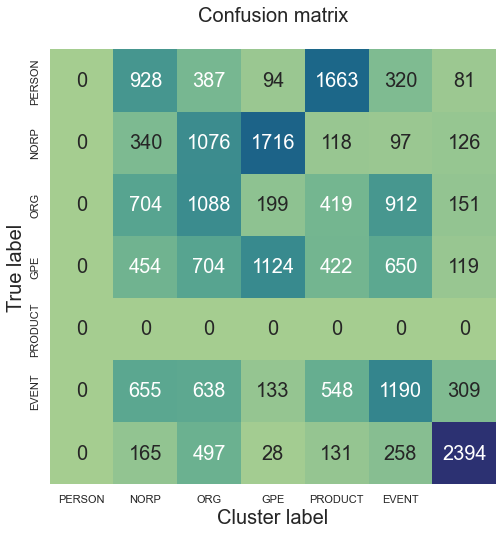

In [30]:
plot_confusion(y, y_pred, mapping, 8)

# TF with custom losses for P

In [1]:
import pickle
from tensorflow import keras as k
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from random import shuffle
from data import test_train_split, load_data


In [3]:
embeddings_dims = 768
latent_dims = 256

input_layer = k.Input(shape=(embeddings_dims,))

enc1 = tf.keras.layers.Dense(500)(input_layer)
enc2 = tf.keras.layers.Dense(500)(enc1)
enc3 = tf.keras.layers.Dense(2000)(enc2)

enc_X_out_logits = tf.keras.layers.Dense(latent_dims)(enc3)
encoder = tf.nn.sigmoid(enc_X_out_logits)
encoder_model = tf.keras.Model(inputs=input_layer, outputs=encoder)


dec1 = tf.keras.layers.Dense(2000)(enc_X_out_logits)
dec2 = tf.keras.layers.Dense(500)(dec1)
dec4 = tf.keras.layers.Dense(500)(dec2)

dec_X_out_logits = tf.keras.layers.Dense(embeddings_dims)(dec4)
decoder = tf.nn.sigmoid(dec_X_out_logits)
ae_model = k.models.Model(inputs=input_layer, outputs=decoder)


lat1 = tf.keras.layers.Dense(2000)(enc_X_out_logits)
lat2 = tf.keras.layers.Dense(500)(lat1)
lat3 = tf.keras.layers.Dense(500)(lat2)
lat4 = tf.keras.layers.Dense(500)(lat3)
latent_logits = tf.keras.layers.Dense(latent_dims)(lat4)
latent_network = tf.nn.sigmoid(latent_logits)
latent_model = k.models.Model(inputs=input_layer, outputs=latent_network)

model = k.models.Model(inputs=input_layer, outputs=[decoder, latent_network])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [4]:
@tf.function
def pairwise_sqd_distance(X, batch_size):
    tiled = tf.tile(tf.expand_dims(X, axis=1),
                    tf.stack([1, batch_size, 1]))
    tiled_trans = tf.transpose(tiled, perm=[1, 0, 2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

    return sqd_dist_mat

@tf.function
def make_q(z, batch_size, alpha):

    sqd_dist_mat = pairwise_sqd_distance(z, batch_size)
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / (tf.reduce_sum(q, axis=0, keepdims=True)+1e-9)
    #q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)

    return q
    
def batches(x, y, n):
    for i in range(0, (y.shape[0] // n)-1):
        yield x[i*n:(i*n)+n], y[i*n:(i*n)+n]

In [5]:
entities = ['ORG', 'PERSON', 'GPE', 'NORP', 'PRODUCT', 'EVENT' ]
x, y, mapping = load_data(10000, entity_filter=entities)

Loading ./data/conll_spacy_10000.pkl
Done: (11535, 772)
{2: 'ORG', 1: 'NORP', 0: 'PERSON', 3: 'GPE', 6: 'EVENT', 5: 'PRODUCT'}
Train data balance:
[[   0 3472]
 [   1 1399]
 [   2 2975]
 [   3 3473]
 [   5  116]
 [   6  100]]
x: (20838, 768), y: (20838,)


Pretraining
Pretraining final loss 0.22824428975582123
Full training


 20%|██        | 1/5 [00:03<00:14,  3.57s/it]

rec: 0.21586759388446808, lat: 620.055908203125, ratio: 0.0003481421445030719


 40%|████      | 2/5 [00:07<00:10,  3.64s/it]

rec: 0.21586759388446808, lat: 620.055908203125, ratio: 0.0003481421445030719


 60%|██████    | 3/5 [00:10<00:07,  3.63s/it]

rec: 0.21586759388446808, lat: 620.055908203125, ratio: 0.0003481421445030719


 80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

rec: 0.21586759388446808, lat: 620.055908203125, ratio: 0.0003481421445030719


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]

rec: 0.21586759388446808, lat: 620.055908203125, ratio: 0.0003481421445030719


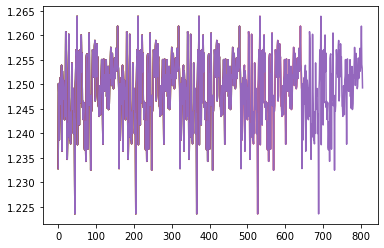

In [12]:
%matplotlib inline

losses = []
alpha1 = 20
alpha2 = 1
rec_weight = 1
latent_weight = 1/600
batch_size = 128
num_epochs = 5

# pretrain ae
print("Pretraining")
pretrain_batches = batches(x, y, batch_size)
for batch_idx, (x_batch, y_batch) in enumerate(pretrain_batches):
    if batch_idx > 20:
        break
    with tf.GradientTape() as tape:
        y_reconst = ae_model(x_batch, training=True)

        reconstr_loss = tf.reduce_mean(
            tf.math.squared_difference(x_batch.astype('float32'), y_reconst))

    gradients = tape.gradient(reconstr_loss, tape.watched_variables())
    # apply gradients for all variables watched by the tape
    opt.apply_gradients((grad, var)
                        for (grad, var) in zip(gradients, tape.watched_variables())
                        if grad is not None)
print(f"Pretraining final loss {reconstr_loss}")

# train full model
print("Full training")
# Prepare the metrics.
train_acc_metric = k.metrics.SparseCategoricalAccuracy()
val_acc_metric = k.metrics.SparseCategoricalAccuracy()
for epoch in tqdm(range(num_epochs)):
    full_batches = batches(x, y, batch_size)
    for batch_idx, (x_batch, y_batch) in enumerate(full_batches):
        with tf.GradientTape() as tape:
            y_reconst = ae_model(x_batch, training=True)
            z_enc = encoder_model(x_batch, training=True)
            l = latent_model(x_batch, training=True)

            p = make_q(l, batch_size, alpha=alpha1)
            q = make_q(z_enc, batch_size, alpha=alpha2)
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))
            reconstr_loss = tf.reduce_mean(
                tf.math.squared_difference(x_batch.astype('float32'), y_reconst))

            # Joint loss.
            joint_loss = rec_weight * reconstr_loss +\
                        latent_weight * latent_loss
            # print(f"LOSS {losses[-1][0]}")
            
            gradients = tape.gradient(joint_loss, tape.watched_variables())
            # apply gradients for all variables watched by the tape
            opt.apply_gradients((grad, var)
                                for (grad, var) in zip(gradients, tape.watched_variables())
                                if grad is not None)
            # Update training metric.
        train_acc_metric.update_state(y_batch, l)
        losses.append(joint_loss)

    # print(losses[-1][0])
    plt.plot(losses)

In [27]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

def cluster_metric(y, z_state, clustering):
    """
    y is labels, not one hot encoded vector.
    """

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
            n_components=n_clusters, covariance_type='full')
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(z_state)
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        y_pred = dbscan.fit_predict(z_state)
    elif clustering == 'OPTICS':
        optics = OPTICS(min_samples=dbscan_min_samples)
        y_pred = optics.fit_predict(z_state)
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    def cluster_acc(y_true, y_pred):
        y_true = y_true.astype(np.int64)
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

    acc = np.round(cluster_acc(y, y_pred), 5)
    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(adjusted_rand_score(y, y_pred), 5)

    print(f'\n{clustering} Accuracy: {acc}, NMI: {nmi}, ARI: {ari}')

    # res = np.ndarray([acc], np.float32)
    return np.ndarray([], np.float32)

In [28]:
from metrics import plot_confusion
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn import mixture
from linear_assignment import linear_assignment

dbscan_eps = 0.2
dbscan_min_samples = 5
n_clusters = np.unique(y).shape[0]
q = latent_model.predict(x, verbose=0)


# evaluate the clustering performance
for cluster_algo in ["GMM", "Kmeans", "DBSCAN", "OPTICS"]:
    cluster_metric(y, q, cluster_algo)


GMM Accuracy: 0.16815, NMI: 0.00192, ARI: 1e-05

Kmeans Accuracy: 0.16815, NMI: 0.00192, ARI: 1e-05

DBSCAN Accuracy: 0.16811, NMI: 0.0017, ARI: 1e-05

OPTICS Accuracy: 0.16801, NMI: 0.00154, ARI: 1e-05


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
